In [1]:
%load_ext autoreload
%autoreload 2

# TODO: This forces us to run on CPU not GPU
# Probably want to remove later...
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from functools import partial
import pdb

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
    seq_contains_mdm2_motif,
    seq_contains_12ca5_motif,
)
from analysis.scatter_plots import (
    plot_relations,
    plot_relations_in_3D,
    plot_relations_in_plotly,
    plot_fancy_hexbin_relations
)
from utils.utils import seed_everything
from models.rnn import multi_channel_mse, er_rmse, fold_rmse, p_value_rmse

2023-06-16 10:33:52.416962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 10:33:52.635246: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-16 10:33:53.317597: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2023-06-16 10:33:53.317657: W ten

In [2]:
protein_of_interest = "mCDH2"
other_proteins = ["MDM2", "12ca5"]
top_k_size = 500 if protein_of_interest in ["MDM2", "mCDH2"] else 1000


volcano_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
result = data_loading.build_dataset(
    lib=volcano_lib,
    protein_of_interest=protein_of_interest,
    other_proteins=other_proteins,
)


> /home/yitongt/ml_phage/src/preprocessing/y_representation.py(85)calculate_anova_f_values()
     81         for other_protein in other_proteins
     82     ]
     83     pdb.set_trace()
     84     # lib["log_pvalues"]
---> 85     sp.stats.f_oneway(distributions)

[         0      1      2      3      4      5      6      7      8      9      \
mCDH2 1   1843     58      8     13     14     10     12      8     12      7   
mCDH2 2     56      1      0      1      0      0      0      0      0      1   
mCDH2 3     54      1      0      0      0      0      0      1      0      0   

         ...  63974  63975  63976  63977  63978  63979  63980  63981  63982  \
mCDH2 1  ...      0      0      0      0      0      0      0      0      0   
mCDH2 2  ...      0      0      0      0      0      0      0      0      0   
mCDH2 3  ...      0      0      0      0      0      0      0      0      0   

         63983  
mCDH2 1      0  
mCDH2 2      0  
mCDH2 3      0  

[3 rows x 63982 column

/home/yitongt/.conda/envs/subcell_loc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3903: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


F_onewayResult(statistic=array([3.76867973e+03, 2.19421178e+03, 6.51874142e+03, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]), pvalue=array([5.03221677e-10, 2.54535293e-09, 9.73358973e-11, ...,
       4.21875000e-01, 4.21875000e-01, 4.21875000e-01]))


In [40]:
def pval_filter_ranking_lambda(x):
    return x[1] + x[2]
    # if x[0] > - np.log(0.01): # else try 2 #- np.log(0.01):
    #     return x[1] + x[2]
    # else:
    #     return 0


def cross_validate_and_benchmark(
    model_save_name="final_models/Joint_loss_model_fixed_volume.h5"
    if protein_of_interest == "MDM2"
    else "final_models/Joint_loss_model_fixed_volume_12ca5.h5",
    loss=multi_channel_mse,
    load_trained_model=False,
    calculate_proxy_uncertainty=True,
    ranking_lambda=pval_filter_ranking_lambda,
    plot_x_idx=1,  # TODO: these arguments are not clear in the least... make these clearer
    plot_y_idx=0,  # TODO: these arguments are not clear in the least... make these clearer
    width=64,
    motif_dectection_func=seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif,
):
    seed_everything(0)
    results = experiment.Experiment().run_cross_validation_experiment(
        X=X,
        y=y_raw,
        model_architecture=partial(
            rnn.ThreeChannelRegressionRNN_gelu, loss=loss, width=width
        ),
        optimizer=partial(
            keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5
        ),
        n_splits=10,
        load_trained_model=load_trained_model,
        model_save_name=model_save_name,
        normalize=True,
        batch_size=128,
        num_epochs=5,
    )

    y_pred = np.vstack(result.y_pred_rescaled for result in results)
    y_true = np.vstack(result.y_test for result in results)
    # Check that the cross folds experiment returns our y_true in the same order as before
    assert (y_true == y_raw).all()

    all_positives = np.array(
        [1.0 if motif_dectection_func(pep) else 0.0 for pep in peptides]
    )
    if calculate_proxy_uncertainty:
        # Calculate with dropout on...
        pred_100_fold = []
        for result in results:
            pred_100_fold.append(
                np.array(
                    [
                        result.trained_model(result.X_test, training=True)
                        for _ in range(100)
                    ]
                )
            )
        pred_100_fold = np.concatenate(pred_100_fold, axis=1)

        mean = np.mean(pred_100_fold, axis=0)
        variance = np.std(pred_100_fold, axis=0)
        uncertainty = np.mean(variance, axis=1)

        mdm2_ordering = [ranking_lambda(pred) for pred in mean]
        plot_relations_in_3D(
            plot_x_idx,
            plot_y_idx,
            datapoints=mean,
            title="Predicted Hits Coloring",
            ordering=mdm2_ordering,
            all_positives=all_positives,
            uncertainty=uncertainty,
        )
        y_pred = mean
    else:
        mdm2_ordering = [ranking_lambda(pred) for pred in y_pred]
        # plot_relations(
        #     plot_x_idx,
        #     plot_y_idx,
        #     datapoints=y_pred,
        #     ordering=mdm2_ordering,
        #     all_positives=all_positives,
        #     kind="scatter",
        # )
    plot_fancy_hexbin_relations(
        plot_x_idx,
        plot_y_idx,
        datapoints=y_pred,
        ordering=mdm2_ordering,
        all_positives=None,  # all_positives,
        line_color="#F94040",
        vals=[
            "Predicted -log(P-value)",
            "Predicted log(Fold Change)",
            "Predicted Enrichment Ratio",
        ],
        top_k=top_k_size,
    )
    plot_fancy_hexbin_relations(
        plot_x_idx,
        plot_y_idx,
        datapoints=y_pred,
        ordering=None,  # mdm2_ordering,
        all_positives=all_positives,
        line_color="#F94040",
        vals=[
            "Predicted -log(P-value)",
            "Predicted log(Fold Change)",
            "Predicted Enrichment Ratio",
        ],
        top_k=top_k_size,
    )
    return mdm2_ordering, y_pred


In [20]:
def show_volcano(
    y,
    title,
    x_label,
    y_label,
    mdm2_ordering=None,
    ca5_ordering=None,
    line_slope=None,
):
    sns.set_palette(sns.color_palette("plasma"))
    p = sns.jointplot(
        x=y[:, 1],
        y=y[:, 0],
        color="grey",
        alpha=0.4,
        marginal_kws=dict(bins=50, fill=False),
    )
    if mdm2_ordering is not None:
        top_mdm2_mask = mdm2_ordering >= np.partition(mdm2_ordering, kth=-top_k_size)[-top_k_size]
        plt.scatter(
            x=y[top_mdm2_mask][:, 1],
            y=y[top_mdm2_mask][:, 0],
            color="#F94040",
            alpha=0.8,
        )
    if ca5_ordering is not None:
        top_ca5_mask = ca5_ordering >= np.partition(ca5_ordering, kth=-top_k_size)[-top_k_size]
        plt.scatter(
            x=y[top_ca5_mask][:, 1],
            y=y[top_ca5_mask][:, 0],
            color="blue",
            alpha=0.8,
        )

    p.fig.suptitle(title)
    p.set_axis_labels(x_label, y_label)
    p.fig.subplots_adjust(top=0.95)  # Reduce plot to make room


# Joint Model

/tmp/ipykernel_2898480/2786201871.py:42: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred_rescaled for result in results)
/tmp/ipykernel_2898480/2786201871.py:43: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for result in results)


(-9.223680770377001, 2.9162414467027618, -4.212047333033321, 8.26147482014639)


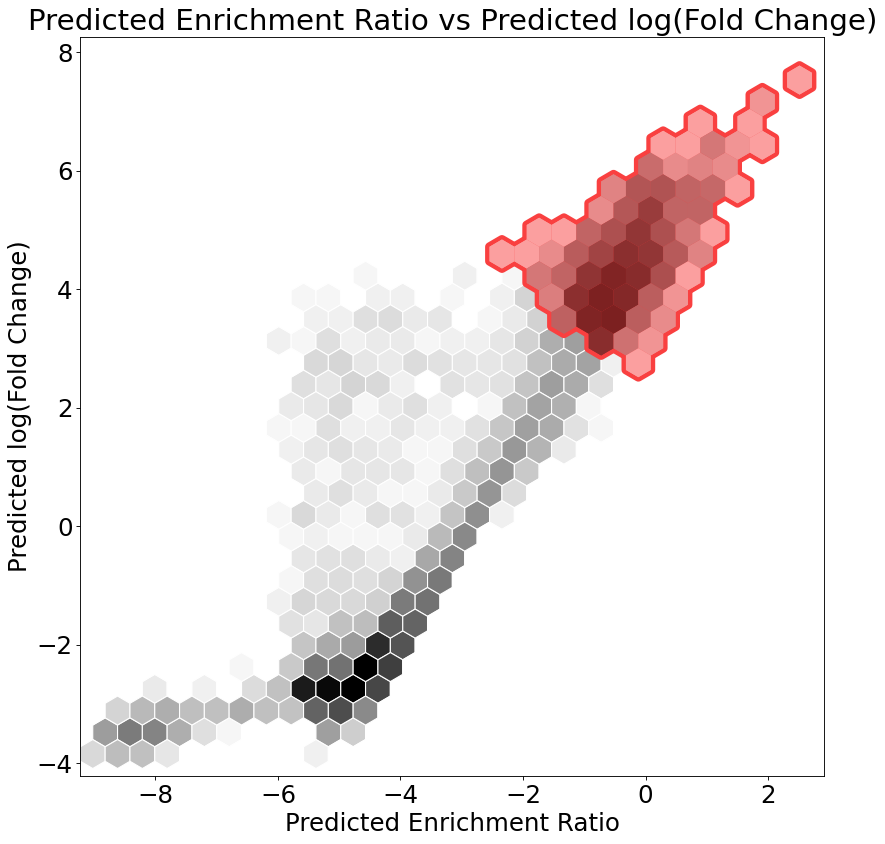

(-9.223680770377001, 2.9162414467027618, -4.212047333033321, 8.26147482014639)


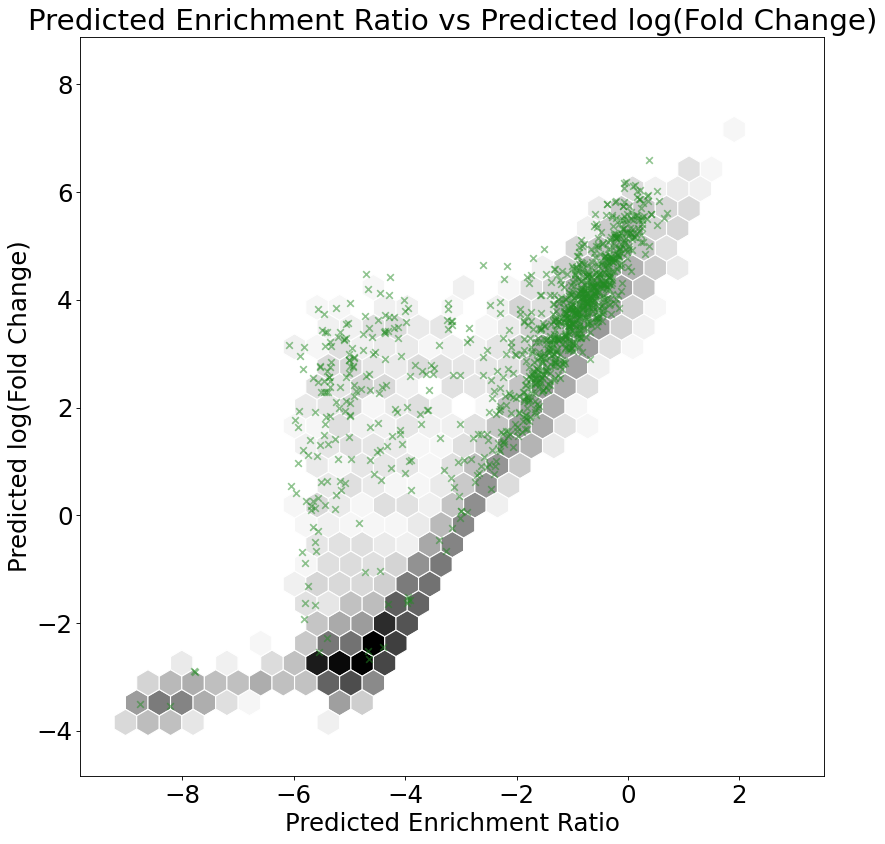

In [41]:
bilstm_ordering, y_pred = cross_validate_and_benchmark(
    model_save_name="final_models/Joint_loss_model_fixed_volume.h5"
    if protein_of_interest == "MDM2"
    else "final_models/Joint_loss_model_fixed_volume_12ca5.h5",
    loss=multi_channel_mse,
    load_trained_model=True,
    calculate_proxy_uncertainty=False,
    ranking_lambda=pval_filter_ranking_lambda, # x[0] 
    plot_x_idx=2,
    plot_y_idx=1,
    width=128
)


In [22]:
print(np.median(y_pred[:, 0]))
print(-np.log(0.01))

2.4393584157464514
4.605170185988091


In [23]:
np.max(bilstm_ordering)

10.037430529579938

With 100 fold uncertainty calculation to help zero in on the mean

In [24]:
# bilstm_ordering_ensemble =cross_validate_and_benchmark(
#     model_save_name="final_models/Joint_loss_model.h5",
#     loss=multi_channel_mse,
#     load_trained_model=True,
#     calculate_proxy_uncertainty=True,
#     ranking_lambda=pval_filter_ranking_lambda,
#     plot_x_idx=2,
#     plot_y_idx=1,
#     width=128
# )

In [25]:
y = y_raw #_test
# Slight bump to pvalue for MDM2 since pvalue is so low...
volcano_ordering = np.array([(val[0]+6) * val[1] if val[1] > 0 else 0 for val in y]) if protein_of_interest == 'MDM2' else np.array([val[0] * val[1] for val in y])
# volcano_mdm2_ordering = np.array([(val[0]+6) * val[1] if val[1] > 0 else 0 for val in y])
# volcano_ca5_ordering = np.array([-val[0] * val[1] if val[1] < 0 else 0 for val in y])
# show_volcano(
#     y,
#     title=f"Volcano plot {protein_of_interest} vs {other_protein}",
#     x_label="log fold change",
#     y_label="- log p-value",
#     mdm2_ordering=volcano_mdm2_ordering,
#     ca5_ordering=volcano_ca5_ordering,
# )

# all_positives = np.array(
#     [1.0 if seq_contains_mdm2_motif(pep) else 0.0 for pep in peptides]
# )
# plot_relations(
#     1,
#     0,
#     datapoints=y_raw,
#     ordering=volcano_mdm2_ordering,
#     all_positives=all_positives,
#     kind="scatter",
# )

In [26]:
all_positives = np.array(
    [1.0 if seq_contains_mdm2_motif(pep) else 0.0 for pep in peptides]
)
# TODO: we are only dealing with 475 true cases for MDM2! That means our true positive lines should be curved downward!
# all_positives.sum()
y_raw[all_positives.astype(bool)].shape
# all_positives.astype(int).sum()

(559, 3)

In [27]:
len(y_raw[all_positives.astype(int)])

32911

(-10.735610373902963, 13.334223068602926, -0.8329379238887278, 27.369964117469774)


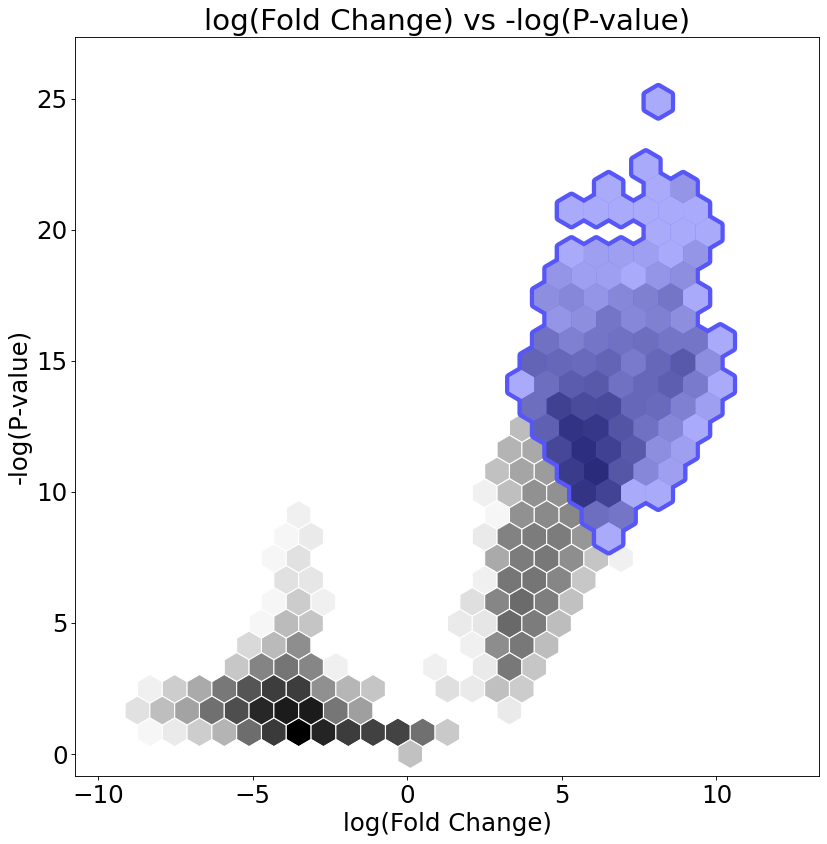

(-10.735610373902963, 13.334223068602926, -0.8329379238887278, 27.369964117469774)


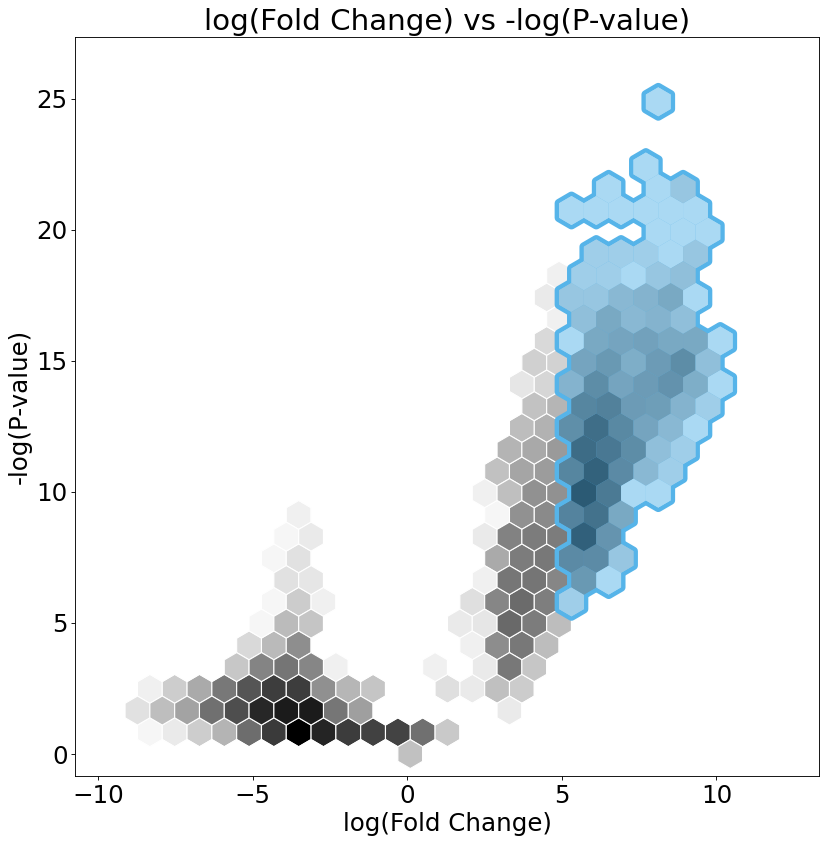

(-18.34857663886301, 12.263528443333284, -10.735610373902963, 13.334223068602926)


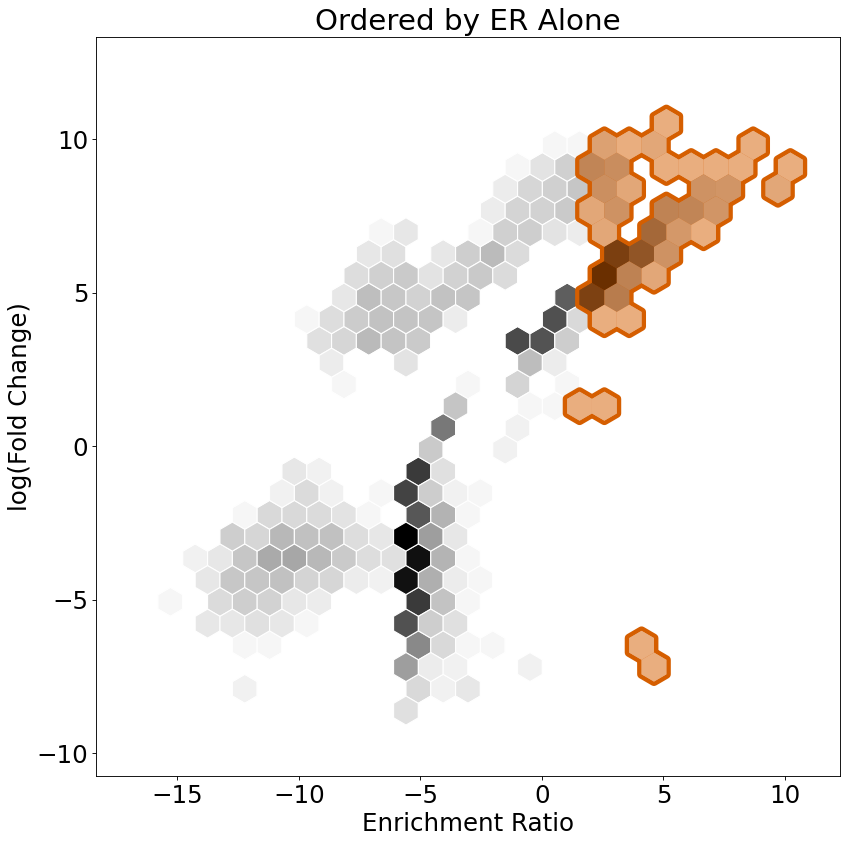

(-18.34857663886301, 12.263528443333284, -10.735610373902963, 13.334223068602926)


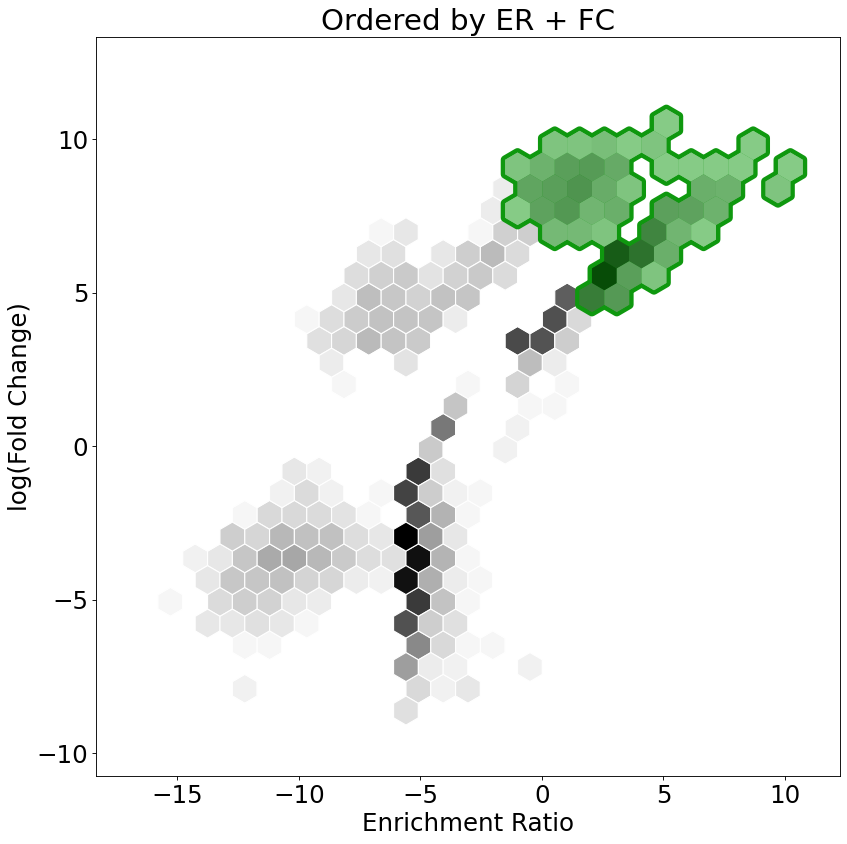

In [39]:
# volcano_mdm2_ordering #5757F9 fc_alone_mdm2_ordering #56B4E9 er_mdm2_ordering #D55E00 er_fc_joint_mdm2_ordering #0F980F
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=volcano_ordering,
    all_positives=None,#all_positives,
    line_color='#5757F9',
    top_k=top_k_size,
)

fc_alone_mdm2_ordering = [y[1] for y in y_raw]
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=fc_alone_mdm2_ordering,
    all_positives=None,#all_positives,
    line_color='#56B4E9',
    top_k=top_k_size,
)

er_mdm2_ordering = [y[2] for y in y_raw]

plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_mdm2_ordering,
    all_positives=None,#all_positives,
    line_color='#D55E00',
    title='Ordered by ER Alone',
    top_k=top_k_size,
)

er_fc_joint_mdm2_ordering = [y[2] + y[1] for y in y_raw]
plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_fc_joint_mdm2_ordering,
    all_positives=None,#all_positives,
    line_color='#0F980F',
    title='Ordered by ER + FC',
    top_k=top_k_size,
)


/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))
/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))


drop C
max is  294.0
drop C
max is  178.0


/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))
/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))


drop C
max is  188.0
drop C
max is  133.0


/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))


drop C
max is  141.0


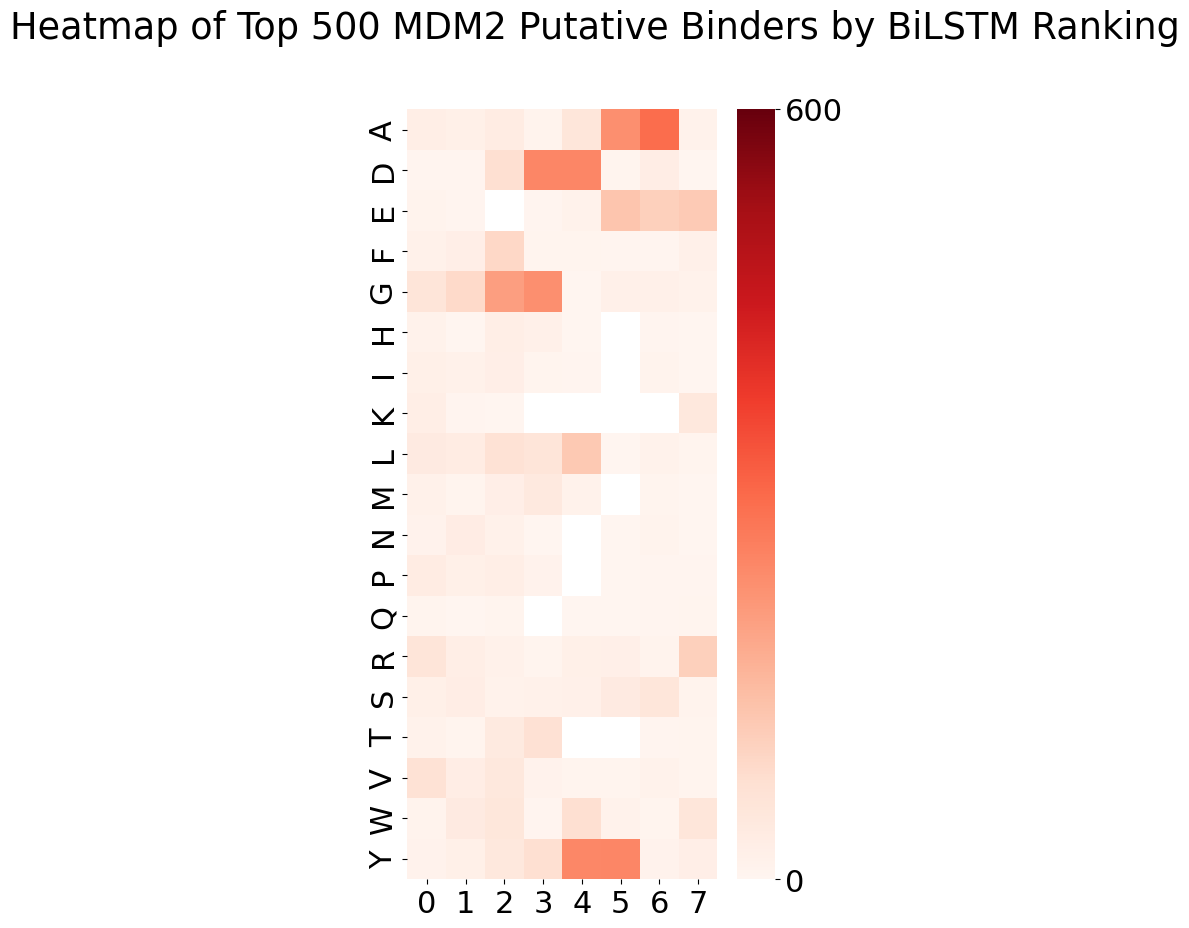

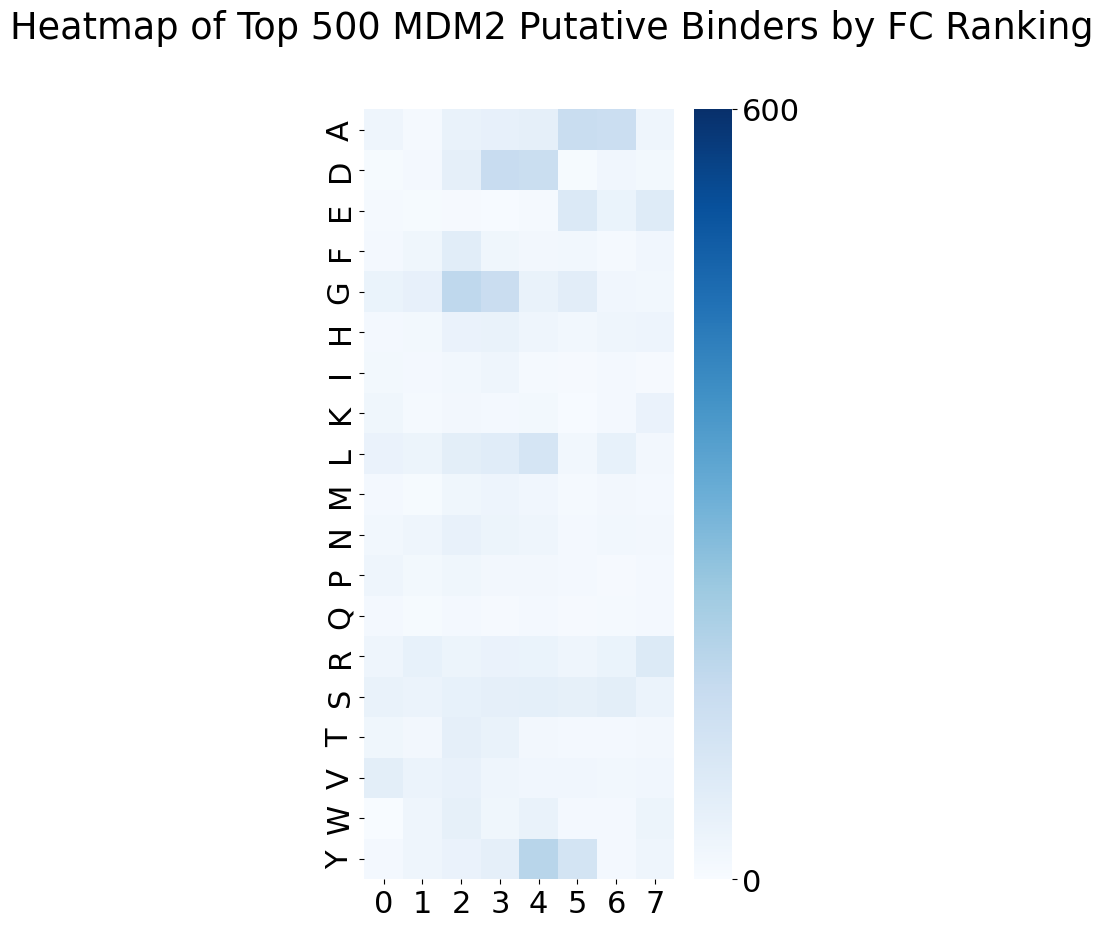

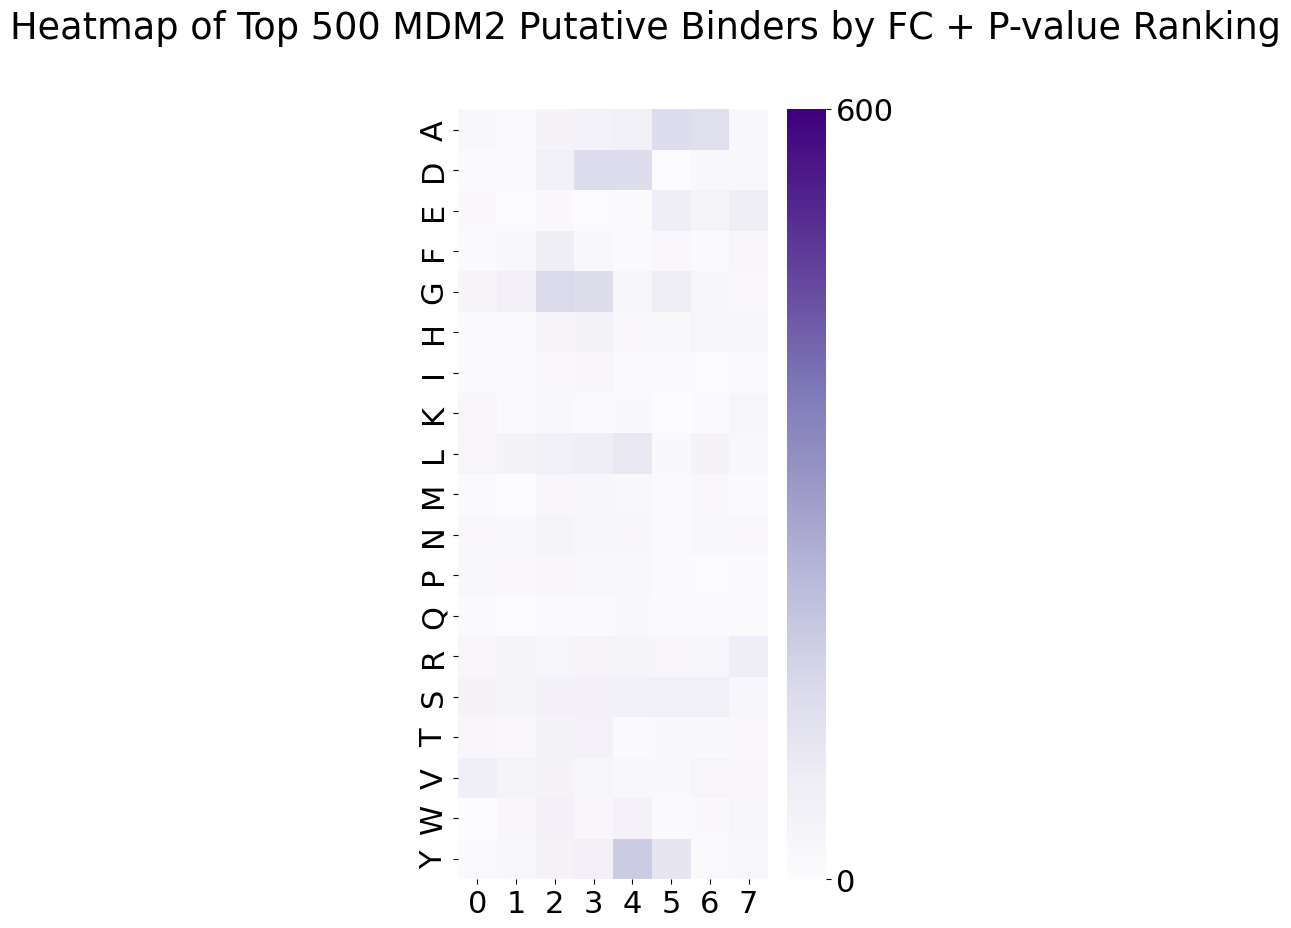

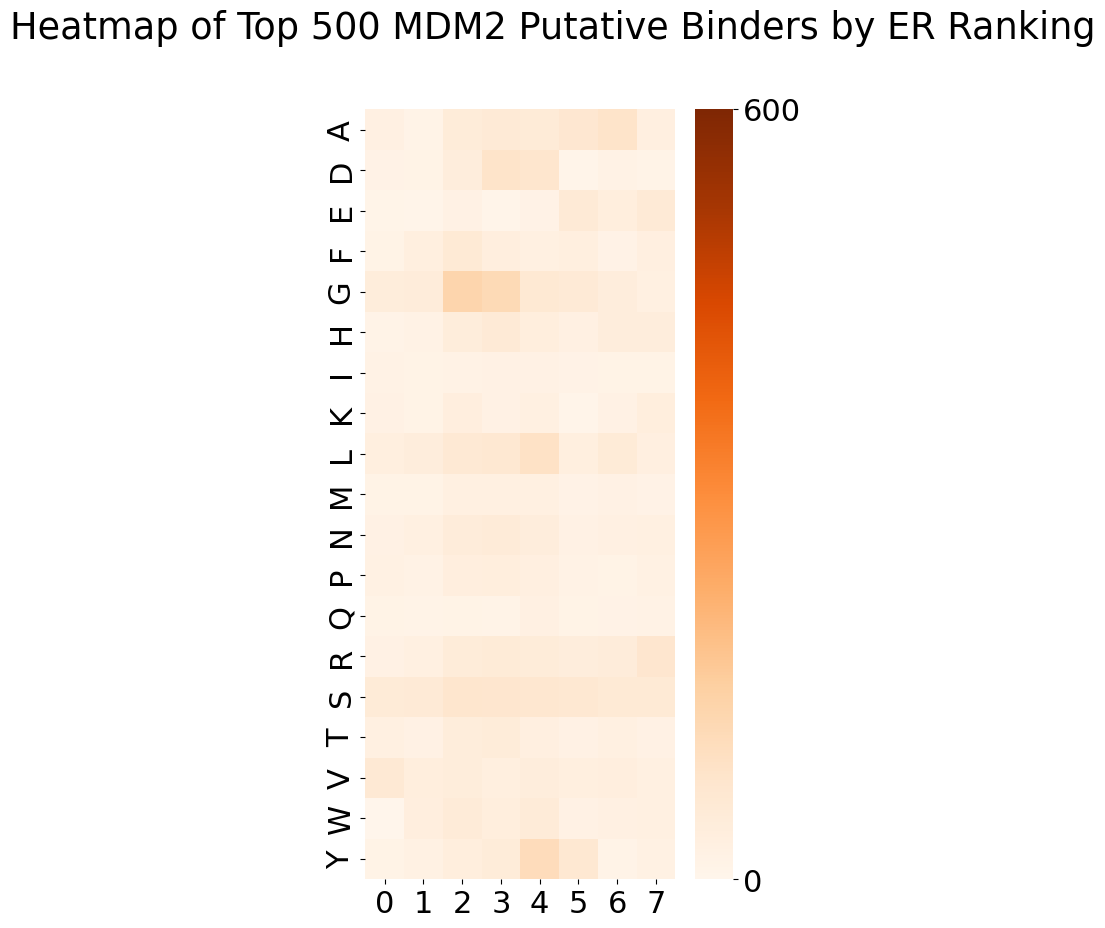

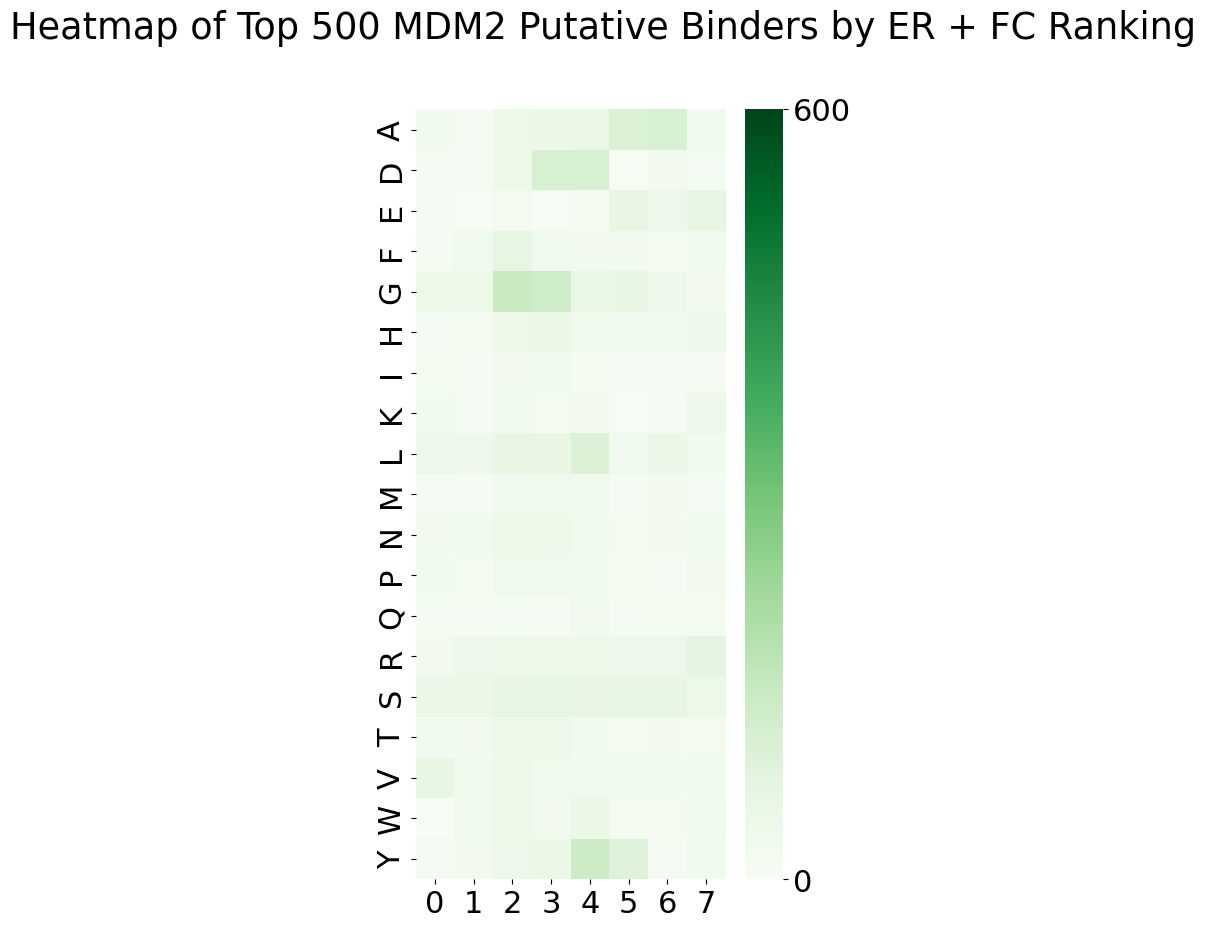

In [38]:
import analysis.heatmap_analysis as heatmap




def show_heatmap_for_top_k(title, ordering, color, peptides=peptides, top_k=top_k_size):
    top_k_mask = ordering >= np.partition(ordering, kth=-top_k)[-top_k]
    top_k_peptides = [pep for pep, mask in zip(peptides, top_k_mask) if mask]
    # print('Out of ', len(top_k_peptides), ' we have this many hits: ', len([seq for seq in top_k_peptides if  seq_contains_mdm2_motif(seq)]))

    heatmap.generate_heatmap(
        top_k_peptides, 
        title=title,
        vmax=600,
        colormap=color,
    )

show_heatmap_for_top_k('Heatmap of Top 500 MDM2 Putative Binders by BiLSTM Ranking', bilstm_ordering, 'Reds')
show_heatmap_for_top_k('Heatmap of Top 500 MDM2 Putative Binders by FC Ranking', fc_alone_mdm2_ordering, 'Blues')
show_heatmap_for_top_k('Heatmap of Top 500 MDM2 Putative Binders by FC + P-value Ranking', volcano_ordering, 'Purples')
show_heatmap_for_top_k('Heatmap of Top 500 MDM2 Putative Binders by ER Ranking', er_mdm2_ordering, 'Oranges')
show_heatmap_for_top_k('Heatmap of Top 500 MDM2 Putative Binders by ER + FC Ranking', er_fc_joint_mdm2_ordering, 'Greens')



# print('the intersect of the two groups is: ', len(set(top_k_er_peptides).intersection(set(top_k_volcano_peptides))))
# print('tehse are the er specific peptides: ', set(top_k_er_peptides)-set(top_k_er_peptides).intersection(set(top_k_volcano_peptides)))
# print('tehse are the volcano specific peptides: ', set(top_k_volcano_peptides)-set(top_k_er_peptides).intersection(set(top_k_volcano_peptides)))

In [30]:

rankings=[
(
    bilstm_ordering, 'BiLSTM Model Ranking', '#F94040'
),
(
    er_mdm2_ordering, 'ER Ranking', '#D55E00'
),
(
    er_fc_joint_mdm2_ordering, 'Joint ER/FC Ranking', '#0F980F'
),
(
    volcano_ordering, 'Joint FC/Pval Ranking', '#5757F9'
),
(
    fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9'
),
]

In [31]:
from matplotlib.pyplot import figure

figure(figsize=(12, 12), dpi=80)

<Figure size 960x960 with 0 Axes>

<Figure size 960x960 with 0 Axes>

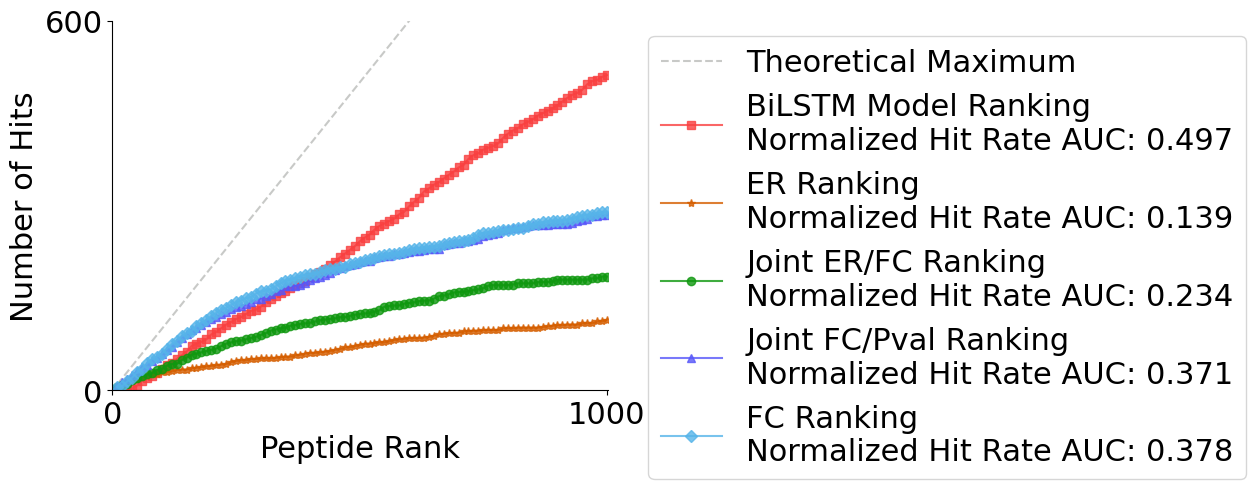

0.49665346534653465

In [37]:
plot_ratio_by_ranking(
    peptides=peptides,
    y_rankings=rankings,
    title="",
    peptide_dataset_size=top_k_size,
    hit_rate_func=seq_contains_mdm2_motif if protein_of_interest =="MDM2" else seq_contains_12ca5_motif,
    save_file='mdm2_hit_rankings.csv' if protein_of_interest =='MDM2' else '12ca5_hit_rankings.csv',
)